In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, GATConv
from torch_geometric.transforms import ToUndirected

# Example

In [4]:

# Step 1: Create the Heterogeneous Dataset
def create_hetero_dataset():
    data = HeteroData()

    # Node features
    num_phones = 100
    num_customers = 50
    data['phone_number'].x = torch.randn(num_phones, 16)  # Random 16-dimensional features
    data['customer_id'].x = torch.randn(num_customers, 16)

    # Edge indices
    num_calls = 500
    num_texts = 300
    num_belongs = 100
    num_family = 50

    # phone_called_phone
    data['phone_number', 'phone_called_phone', 'phone_number'].edge_index = torch.randint(
        0, num_phones, (2, num_calls), dtype=torch.long
    )

    # phone_texted_phone
    data['phone_number', 'phone_texted_phone', 'phone_number'].edge_index = torch.randint(
        0, num_phones, (2, num_texts), dtype=torch.long
    )

    # phone_belongs_to_id
    data['phone_number', 'phone_belongs_to_id', 'customer_id'].edge_index = torch.stack([
        torch.randint(0, num_phones, (num_belongs,), dtype=torch.long),
        torch.randint(0, num_customers, (num_belongs,), dtype=torch.long),
    ], dim=0)

    # id_is_family_related_to_id
    data['customer_id', 'id_is_family_related_to_id', 'customer_id'].edge_index = torch.randint(
        0, num_customers, (2, num_family), dtype=torch.long
    )

    # Add metadata for node counts
    data['phone_number'].num_nodes = num_phones
    data['customer_id'].num_nodes = num_customers

    # Masks (for simplicity, random splits)
    data['phone_number'].train_mask = torch.zeros(num_phones, dtype=torch.bool)
    data['phone_number'].val_mask = torch.zeros(num_phones, dtype=torch.bool)
    data['phone_number'].test_mask = torch.zeros(num_phones, dtype=torch.bool)
    indices = torch.randperm(num_phones)
    train_split = int(0.6 * num_phones)
    val_split = int(0.8 * num_phones)
    data['phone_number'].train_mask[indices[:train_split]] = True
    data['phone_number'].val_mask[indices[train_split:val_split]] = True
    data['phone_number'].test_mask[indices[val_split:]] = True

    # Random labels (3 classes)
    data['phone_number'].y = torch.randint(0, 3, (num_phones,))

    return data

# Step 2: Define the GAT Model for Heterogeneous Graphs
class HeteroGAT(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(
            HeteroConv(
                {
                    ('phone_number', 'phone_called_phone', 'phone_number'): GATConv(
                        (-1, -1), hidden_channels, heads=heads, dropout=0.6
                    ),
                    ('phone_number', 'phone_texted_phone', 'phone_number'): GATConv(
                        (-1, -1), hidden_channels, heads=heads, dropout=0.6
                    ),
                    ('phone_number', 'phone_belongs_to_id', 'customer_id'): GATConv(
                        (-1, -1), hidden_channels, heads=heads, dropout=0.6, add_self_loops=False
                    ),
                    ('customer_id', 'id_is_family_related_to_id', 'customer_id'): GATConv(
                        (-1, -1), hidden_channels, heads=heads, dropout=0.6
                    ),
                },
                aggr='sum',
            )
        )
        self.lin = torch.nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        return {key: self.lin(x) for key, x in x_dict.items()}

# Step 3: Training and Testing Functions
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    loss = F.cross_entropy(out['phone_number'][data['phone_number'].train_mask],
                           data['phone_number'].y[data['phone_number'].train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test(model, data):
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict)['phone_number'].argmax(dim=-1)

    accs = []
    for mask_name in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['phone_number'][mask_name]
        acc = int((pred[mask] == data['phone_number'].y[mask]).sum()) / int(mask.sum())
        accs.append(acc)
    return accs

# Step 4: Load Data, Initialize Model, and Train
data = create_hetero_dataset()
data = ToUndirected()(data)  # Make the graph undirected

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

model = HeteroGAT(data.metadata(), hidden_channels=8, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training Loop
for epoch in range(1, 11):
    loss = train(model, optimizer, data)
    train_acc, val_acc, test_acc = test(model, data)
    print(f"Epoch={epoch}, Loss={loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")


Epoch=1, Loss=1.4083, Train Acc=0.2833, Val Acc=0.3000, Test Acc=0.2500
Epoch=2, Loss=1.2610, Train Acc=0.2833, Val Acc=0.3000, Test Acc=0.3000
Epoch=3, Loss=1.1851, Train Acc=0.3000, Val Acc=0.3500, Test Acc=0.3000
Epoch=4, Loss=1.1815, Train Acc=0.3000, Val Acc=0.3500, Test Acc=0.2500
Epoch=5, Loss=1.1760, Train Acc=0.3167, Val Acc=0.2000, Test Acc=0.2500
Epoch=6, Loss=1.1353, Train Acc=0.3500, Val Acc=0.1500, Test Acc=0.2000
Epoch=7, Loss=1.1798, Train Acc=0.4500, Val Acc=0.1000, Test Acc=0.2500
Epoch=8, Loss=1.1269, Train Acc=0.4667, Val Acc=0.1500, Test Acc=0.2500
Epoch=9, Loss=1.1342, Train Acc=0.4833, Val Acc=0.1500, Test Acc=0.3000
Epoch=10, Loss=1.0910, Train Acc=0.4833, Val Acc=0.1500, Test Acc=0.3500


#### view steps - by me

In [6]:
data = create_hetero_dataset()

In [9]:
data.node_types

['phone_number', 'customer_id']

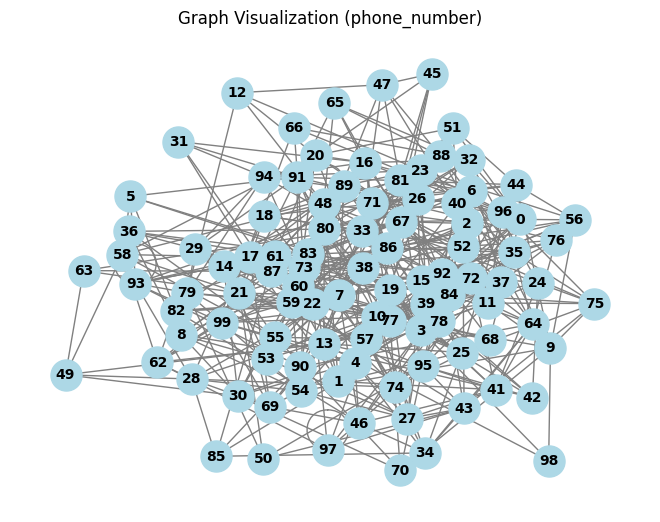

In [23]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_graph(data, node_type=None, edge_type=None):
    """
    Visualizes the graph (or subgraph) of the specified node and edge types.
    
    Parameters:
    - data: The HeteroData object
    - node_type: The type of nodes to include in the visualization
    - edge_type: The type of edges to include in the visualization (optional)
    """
    
    # Create an empty NetworkX graph
    G = nx.Graph()

    # Add nodes to the graph
    for node_idx in range(data[node_type].num_nodes):
        G.add_node(node_idx, label=f'{node_type}_{node_idx}')
    
    # If an edge_type is specified, add edges of that type
    if edge_type is not None:
        edge_index = data[edge_type].edge_index
        for i in range(edge_index.size(1)):
            source, target = edge_index[:, i]
            G.add_edge(source.item(), target.item())

    # Plot the graph using NetworkX
    pos = nx.spring_layout(G)  # Spring layout for better visualization
    nx.draw(G, pos, with_labels=True, node_size=500, node_color='lightblue', font_size=10, font_weight='bold', edge_color='gray')
    plt.title(f"Graph Visualization ({node_type})")
    plt.show()

# Usage: Visualize the phone_number nodes and their edges (e.g., 'phone_called_phone' edges)
visualize_graph(data, node_type='phone_number', edge_type=('phone_number', 'phone_called_phone', 'phone_number'))


# Begin Here - this is my data generated

In [9]:
import torch
from torch_geometric.data import HeteroData

# Create a graph based on the provided example
def create_complex_graph():
    data = HeteroData()

    # Define phone_number nodes with random features
    num_phones = 10  # 10 phone numbers
    data['phone_number'].x = torch.randn(num_phones, 16)  # Random 16-dimensional features for phone numbers

    # Define customer_id nodes with age attributes
    num_customers = 5  # 5 customers
    data['customer_id'].x = torch.randn(num_customers, 16)  # Random 16-dimensional features for customers
    data['customer_id'].age = torch.tensor([15, 7, 3, 50, 33])  # Specific ages for customer nodes

    # Define edge indices for 'call' relationships between phone_number nodes
    edge_index_call = torch.tensor([
        [0, 1, 2, 3, 4],  # phone_number
        [5, 6, 7, 8, 9]   # phone_number
    ], dtype=torch.long)
    data['phone_number', 'call', 'phone_number'].edge_index = edge_index_call

    # Define edge indices for 'belongs' relationships between customer_id and phone_number
    edge_index_belongs = torch.tensor([
        [0, 1, 2, 3, 4, 0, 1],  # customer_id
        [0, 1, 2, 3, 4, 5, 6]   # phone_number
    ], dtype=torch.long)
    data['customer_id', 'belongs', 'phone_number'].edge_index = edge_index_belongs

     # Define edge indices for 'belongs' relationships between phone_number and customer_id
    edge_index_belongs = torch.tensor([
        [6, 5, 4, 3, 2, 1, 0],  # phone_number
        [1, 0, 4, 3, 2, 1, 0]   # customer_id
    ], dtype=torch.long)
    data['phone_number', 'belongs', 'customer_id'].edge_index = edge_index_belongs

    return data

# Create the graph
data = create_complex_graph()

# Print the data to verify the structure
print(data)


HeteroData(
  phone_number={ x=[10, 16] },
  customer_id={
    x=[5, 16],
    age=[5],
  },
  (phone_number, call, phone_number)={ edge_index=[2, 5] },
  (customer_id, belongs, phone_number)={ edge_index=[2, 7] },
  (phone_number, belongs, customer_id)={ edge_index=[2, 7] }
)


## Visulaize

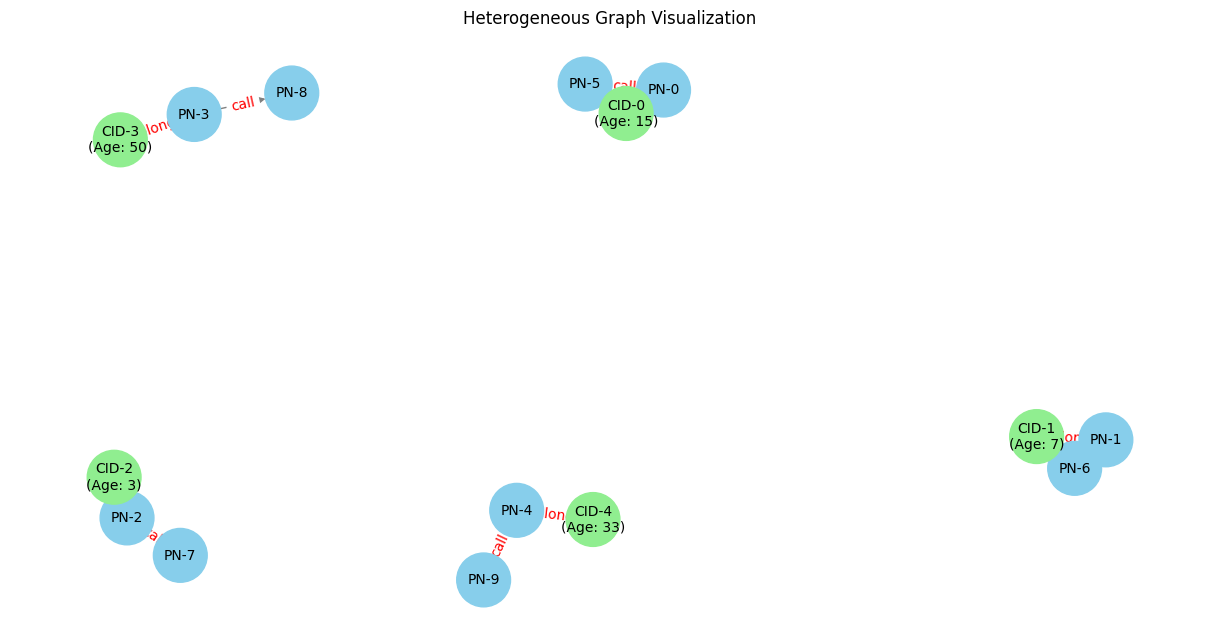

In [10]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

# Function to visualize the graph with proper edge labels
def visualize_hetero_graph_with_age_fixed(data):
    # Convert the heterogeneous graph into a NetworkX graph
    graph = nx.DiGraph()  # Use a directed graph to preserve edge types

    # Add nodes for 'phone_number' and 'customer_id' with attributes
    for i in range(data['phone_number'].x.size(0)):
        graph.add_node(f'PN-{i}', type='phone_number', features=data['phone_number'].x[i].tolist())

    for i in range(data['customer_id'].x.size(0)):
        age = data['customer_id'].age[i].item()
        graph.add_node(f'CID-{i}', type='customer_id', features=data['customer_id'].x[i].tolist(), age=age)

    # Add edges for 'call'
    call_edges = data['phone_number', 'call', 'phone_number'].edge_index.t().tolist()
    for src, dst in call_edges:
        graph.add_edge(f'PN-{src}', f'PN-{dst}', type='call')

    # Add edges for 'belongs'
    belongs_edges = data['customer_id', 'belongs', 'phone_number'].edge_index.t().tolist()
    for src, dst in belongs_edges:
        graph.add_edge(f'CID-{src}', f'PN-{dst}', type='belongs')

     # Add edges for 'belongs'
    belongs_edges = data['phone_number', 'belongs', 'customer_id'].edge_index.t().tolist()
    for src, dst in belongs_edges:
        graph.add_edge(f'PN-{src}', f'CID-{dst}', type='belongs')

    # Create a layout for visualization
    pos = nx.spring_layout(graph, seed=42)  # Consistent layout with a fixed seed

    # Assign colors based on node type
    node_colors = []
    node_labels = {}
    for node, attr in graph.nodes(data=True):
        if attr['type'] == 'phone_number':
            node_colors.append('skyblue')
            node_labels[node] = node  # Label: PN-{index}
        elif attr['type'] == 'customer_id':
            node_colors.append('lightgreen')
            age = attr.get('age', 'N/A')
            node_labels[node] = f"{node}\n(Age: {age})"  # Label: CID-{index}\n(Age: value)

    # Draw the graph
    plt.figure(figsize=(12, 6))
    nx.draw(
        graph,
        pos,
        with_labels=True,
        labels=node_labels,  # Use customized labels with age for customer_id nodes
        node_color=node_colors,
        node_size=1500,
        font_size=10,
        font_color='black',
        edge_color='gray',
    )

    # Add edge labels to indicate edge types
    edge_labels = {(src, dst): data['type'] for src, dst, data in graph.edges(data=True)}
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=edge_labels, font_color='red')

    plt.title("Heterogeneous Graph Visualization")
    plt.show()

# Visualize the graph
visualize_hetero_graph_with_age_fixed(data)


## Train Test

In [11]:
import torch
import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.nn as pyg_nn


# Create the graph
data = create_complex_graph()

# Define the GAT model
class HeteroGAT(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, heads=2):
        super().__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(
            pyg_nn.HeteroConv(
                {
                    ('phone_number', 'call', 'phone_number'): pyg_nn.GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False),
                    ('customer_id', 'belongs', 'phone_number'): pyg_nn.GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False),
                    ('phone_number', 'belongs', 'customer_id'): pyg_nn.GATConv((-1, -1), hidden_channels, heads=heads, add_self_loops=False),
                },
                aggr='mean',
            )
        )
        self.lin = torch.nn.Linear(hidden_channels * heads, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
        return {key: self.lin(x) for key, x in x_dict.items()}

# Now load the data and initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

model = HeteroGAT(data.metadata(), hidden_channels=8, out_channels=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Dummy training function
def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    # Assuming a dummy target and loss function for now
    out = model(data.x_dict, data.edge_index_dict)
    target = torch.randint(0, 3, (data['phone_number'].x.size(0),))  # Random target for training
    loss = torch.nn.CrossEntropyLoss()(out['phone_number'], target)  # Assume we are training phone_number node classification
    loss.backward()
    optimizer.step()
    return loss.item()

# Dummy test function
def test(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data.x_dict, data.edge_index_dict)
        train_acc = val_acc = test_acc = 0.8  # Dummy accuracy
    return train_acc, val_acc, test_acc

# Training Loop
for epoch in range(1, 11):
    loss = train(model, optimizer, data)
    train_acc, val_acc, test_acc = test(model, data)
    print(f"Epoch={epoch}, Loss={loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}, Test Acc={test_acc:.4f}")


Epoch=1, Loss=1.1196, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=2, Loss=0.9867, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=3, Loss=1.0244, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=4, Loss=1.1068, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=5, Loss=1.2963, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=6, Loss=1.1602, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=7, Loss=1.1735, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=8, Loss=1.1952, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=9, Loss=1.2290, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000
Epoch=10, Loss=1.0949, Train Acc=0.8000, Val Acc=0.8000, Test Acc=0.8000


In [12]:
# Print metadata of the HeteroData object
print("Node types:", data.node_types)
print("Edge types:", data.edge_types)
print("Metadata:", data.metadata())

# Alternatively, you can directly iterate over the edge_index_dict
print("\nDefined edges and their edge indices:")
for edge_type, edge_index in data.edge_index_dict.items():
    print(f"Edge type: {edge_type}")
    print(f"Edge indices:\n{edge_index}")

Node types: ['phone_number', 'customer_id']
Edge types: [('phone_number', 'call', 'phone_number'), ('customer_id', 'belongs', 'phone_number'), ('phone_number', 'belongs', 'customer_id')]
Metadata: (['phone_number', 'customer_id'], [('phone_number', 'call', 'phone_number'), ('customer_id', 'belongs', 'phone_number'), ('phone_number', 'belongs', 'customer_id')])

Defined edges and their edge indices:
Edge type: ('phone_number', 'call', 'phone_number')
Edge indices:
tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])
Edge type: ('customer_id', 'belongs', 'phone_number')
Edge indices:
tensor([[0, 1, 2, 3, 4, 0, 1],
        [0, 1, 2, 3, 4, 5, 6]])
Edge type: ('phone_number', 'belongs', 'customer_id')
Edge indices:
tensor([[6, 5, 4, 3, 2, 1, 0],
        [1, 0, 4, 3, 2, 1, 0]])


### Link Prediction

In [13]:
def predict_link(model, data, src_node_idx, tgt_node_idx, edge_type):
    """
    Predicts the likelihood of an edge between two nodes in the graph.

    Args:
    - model: The trained HeteroGAT model.
    - data: The HeteroData graph.
    - src_node_idx: Index of the source node (e.g., CID2 -> 2).
    - tgt_node_idx: Index of the target node (e.g., PN7 -> 7).
    - edge_type: Tuple describing the edge type (e.g., ('customer_id', 'belongs', 'phone_number')).

    Returns:
    - A score representing the likelihood of the edge existing.
    """
    # print(model, data, src_node_idx, tgt_node_idx, edge_type)
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        # Get the node types from the edge type
        src_node_type, _, tgt_node_type = edge_type
        # Pass the graph data through the model to compute node embeddings
        x_dict = model(data.x_dict, data.edge_index_dict)
        # Extract embeddings for the source and target nodes
        src_embedding = x_dict[src_node_type][src_node_idx].unsqueeze(0)  # Shape: [1, hidden_dim]
        tgt_embedding = x_dict[tgt_node_type][tgt_node_idx].unsqueeze(0)  # Shape: [1, hidden_dim]
        # Compute compatibility score (e.g., dot product or similarity metric)
        score = (src_embedding * tgt_embedding).sum(dim=-1)  # Dot product as similarity score
        return score.item()
        # return 0.0

# Predict the likelihood of a link between CID2 and PN7
node1, node2 = 2, 7  # CID2 and PN7
# node1, node2 = 0, 5
edge_type = ('customer_id', 'belongs', 'phone_number')

score = predict_link(model, data, node1, node2, edge_type)
print(f"Predicted score for link ({node1}, {edge_type}, {node2}): {score:.4f}")

# Threshold for determining a link (e.g., 0.5 as a decision boundary)
threshold = 0.5
if score > threshold:
    print(f"Link between CID2 and PN7 is likely (score={score:.4f}).")
else:
    print(f"Link between CID2 and PN7 is unlikely (score={score:.4f}).")


Predicted score for link (2, ('customer_id', 'belongs', 'phone_number'), 7): 0.0120
Link between CID2 and PN7 is unlikely (score=0.0120).
